In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
from PIL import Image
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Input,ZeroPadding2D,BatchNormalization,Activation
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.layers.experimental import preprocessing


from sklearn.metrics import classification_report

In [2]:
# the r in front of the string converts it to a raw string
folder_path = r"C:/Users/arnav/OneDrive/Desktop/UCSD Stuff/3rd Year/Fall/COGS 118B"
No_Tumor_Img = os.listdir(folder_path + '/no/')
Tumor_Img = os.listdir(folder_path + '/yes/')

In [3]:
Classes = {'no':0, 'yes':1}

In [4]:
X = []
y = []
for i in Classes:
    path = r"C:/Users/arnav/OneDrive/Desktop/UCSD Stuff/3rd Year/Fall/COGS 118B/"+i
    for j in os.listdir(path):
        img = cv2.imread(path+'/'+j, 0)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # use the process function to crop the brain and ignore the unnecessary rest part of the image
        
        # resize image
        img = cv2.resize(img, (128,128),interpolation=cv2.INTER_CUBIC)
        # normalize values
        #img = img / 255  #-->Apply normalization because we want pixel values to be scaled to the range 0-1
        X.append(img)
        y.append(Classes[i])

In [5]:
no_image_pixels = []
yes_image_pixels = []
for j in range(len(y)):
    if y[j] == 0:
        no_image_pixels.append(X[j])
    else:
        yes_image_pixels.append(X[j])

In [6]:
# Convert to numpy array 
no_image_pixels_array = np.asarray(no_image_pixels)
yes_image_pixels_array = np.asarray(yes_image_pixels)
no_image_pixels_array = no_image_pixels_array.reshape(98,16384)
yes_image_pixels_array = yes_image_pixels_array.reshape(155,16384)

In [7]:
# Train PCA on 25% of dataset
X_no_train, X_no_test = train_test_split(no_image_pixels_array, test_size = 0.75, random_state = 69)
X_no_test = X_no_test.reshape(74,128,128)
print(X_no_test.shape)
X_no_train = X_no_train.T
print(X_no_train.shape)

X_yes_train, X_yes_test = train_test_split(yes_image_pixels_array, test_size = 0.75, random_state = 69)
#print(X_yes_test.shape)
X_yes_test = X_yes_test[0:116,:]
X_yes_test = X_yes_test.reshape(116,128,128)
print(X_yes_test.shape)
X_yes_train = X_yes_train.T
print(X_yes_train.shape)

# y train, binary option tumor or no tumor
y_no = np.asarray(y[0:98])
y_yes = np.asarray(y[99:254])
y_no_train, y_no_test = train_test_split(y_no, test_size = 0.75, random_state = 12)
y_yes_train, y_yes_test = train_test_split(y_yes, test_size = 0.75, random_state = 12)
print(y_no_test.shape)
print(y_yes_test.shape)

(74, 128, 128)
(16384, 24)
(116, 128, 128)
(16384, 38)
(74,)
(116,)


In [8]:
# Standardization function
def standardize(X):
    # Calculate the mean of each column mu
    mu = np.mean(X,axis=0)
    
    # Subtract the mean from X
    X = X - mu
    
    # Calculate standard deviation of each column
    std = np.std(X,axis=0)
    
    # Handle zero standard deviation case
    std_filled = std.copy()
    std_filled[std==0] = 1.0
    
    # Calculate standardized X
    X_bar = (X-mu)/std_filled
    
    return X_bar, mu, std


In [9]:
# Function to calculate eigenvectors and eigenvalues
def eig(S):
    eig_vec, eig_val = np.linalg.eigh(S)
    # sorting eigenvalues in decreasing order
    # np.argsort returns indices of positions 
    sorted_eig = np.argsort(-eig_val)
    eig_val = eig_val[sorted_eig]
    eig_vec = eig_vec[sorted_eig]
    
    return (eig_vec, eig_val)
    

In [10]:
# Function to calculate projection matrix for reconstruction
def projection(A):
    M = A @ A.T
    return M

In [11]:
## Implement PCA
def PCA(X,mu, num_pcs):
    # Calculate the covariance matrix
    dim = np.shape(X)
    avg = np.tile(np.array([X.mean(axis=1)]).T, (1,dim[1])) 
    Z = X - avg
    N = dim[1]
    cov_matrix = Z.T.dot(Z) / N
    
    # Find eigenvalue and eigenvectors of covariance matrix
    eig_vecs, eig_vals = eig(cov_matrix)
    
    # Select specific eigenvectors
    U = Z.dot(eig_vecs)
    U = U / U.max(axis=0)
    return U
    # Find principal components
    principal_components = U.T.dot()
    X = X[:,0:num_pcs]
    principal_components = U.T * (X-mu)

    # Reconstruct 
    U = U[:,0:num_pcs]
    principal_components = principal_components[0:num_pcs]
    zero_mean_reconstruction = U * principal_components
    reconstruction = zero_mean_reconstruction + mu
    return reconstruction.T


In [12]:
no_pixel_mu = no_image_pixels_array.mean().mean()
yes_pixel_mu = no_image_pixels_array.mean().mean()
x_no_reconstruction = PCA(X_no_train, no_pixel_mu, 5)
x_yes_reconstruction = PCA(X_yes_train, yes_pixel_mu, 5)
x_no_reconstruction.T.shape
x_no_reconstruction = x_no_reconstruction.reshape(24,128,128)
x_no_reconstruction = x_no_reconstruction.reshape(-1,128,128,1)
x_yes_reconstruction.shape

(16384, 38)

In [13]:
# CNN Model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(128,128,1)),
    tf.keras.layers.Conv2D(32,(4,4),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),
                              padding='valid'),
    tf.keras.layers.Conv2D(32,(4,4),activation='relu'),
    tf.keras.layers.Conv2D(16,3,activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      32800     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 32)        16416     
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                    

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(x=x_no_reconstruction, y=y_no_train, epochs=10, validation_data=(X_no_test, y_no_test))

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6966 - accuracy: 0.2917 - val_loss: 2.5017e-23 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 1s 742ms/step - loss: 0.4956 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 1s 764ms/step - loss: 0.2315 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 1s 826ms/step - loss: 0.0437 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 1s 907ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 1s 877ms/step - loss: 2.4092e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 1s 847ms/step - loss: 1.1557e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accu

In [16]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

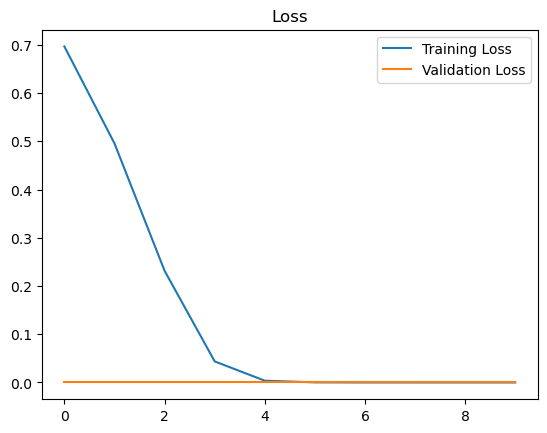

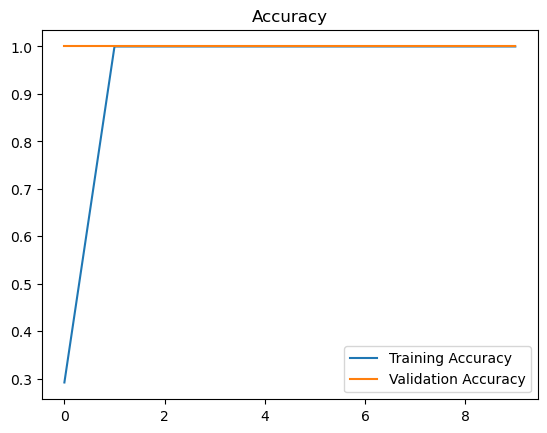

In [17]:
history = model.history.history
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history)

In [18]:
#print(x_yes_reconstruction.shape)
x_yes_reconstruction = x_yes_reconstruction.reshape(38,128,128)
x_yes_reconstruction = x_yes_reconstruction.reshape(-1,128,128,1)
x_yes_reconstruction.shape
X_yes_test.shape

(116, 128, 128)

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(x=x_yes_reconstruction, y=y_yes_train, epochs=10, validation_data=(X_yes_test, y_yes_test))

Epoch 1/10
2/2 [==============================] - 2s 831ms/step - loss: 45.0429 - accuracy: 0.0000e+00 - val_loss: 4454.1484 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 1s 666ms/step - loss: 14.6408 - accuracy: 0.0000e+00 - val_loss: 1188.4412 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 1s 568ms/step - loss: 4.0728 - accuracy: 0.0000e+00 - val_loss: 262.3212 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 1s 588ms/step - loss: 1.2698 - accuracy: 0.0000e+00 - val_loss: 36.8142 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 1s 623ms/step - loss: 0.7586 - accuracy: 0.0000e+00 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 1s 600ms/step - loss: 0.6704 - accuracy: 1.0000 - val_loss: 3.3688e-07 - val_accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 1s 559ms/step - loss: 0.6662 - accuracy: 1.0000 - val_loss:

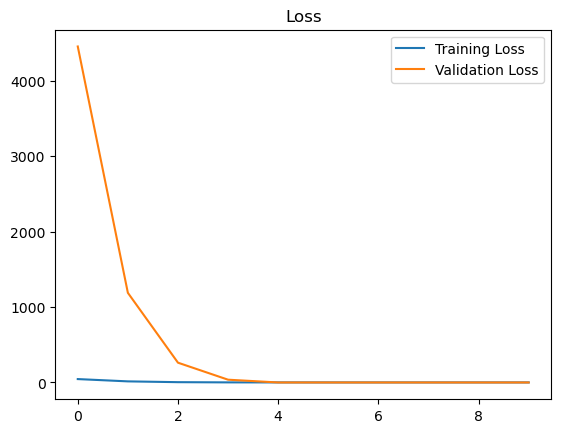

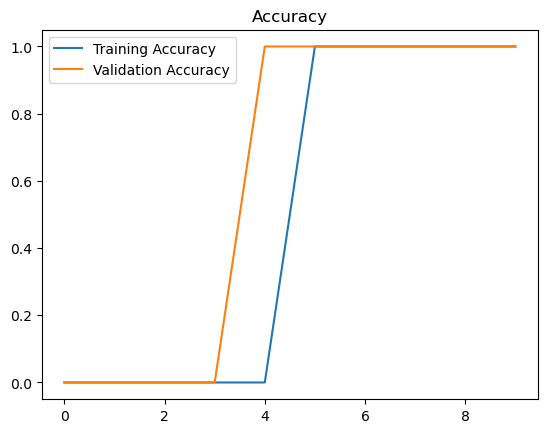

In [21]:
history = model.history.history
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history)

In [43]:
# Train PCA on 50% of dataset
X_no_50_train, X_no_50_test = train_test_split(no_image_pixels_array, test_size = 0.5, random_state = 69)
X_no_50_test = X_no_50_test.reshape(49,128,128)
print(X_no_50_test.shape)
X_no_50_train = X_no_50_train.T
print(X_no_50_train.shape)

X_yes_50_train, X_yes_50_test = train_test_split(yes_image_pixels_array, test_size = 0.5, random_state = 69)
#print(X_yes_test.shape)
X_yes_50_test = X_yes_50_test.reshape(78,128,128)
X_yes_50_test = X_yes_50_test[0:77,:,:]
print(X_yes_50_test.shape)
X_yes_50_train = X_yes_50_train.T
print(X_yes_50_train.shape)

# y train, binary option tumor or no tumor
y_no = np.asarray(y[0:98])
y_yes = np.asarray(y[99:254])
y_no_50_train, y_no_50_test = train_test_split(y_no, test_size = 0.5, random_state = 12)
y_yes_50_train, y_yes_50_test = train_test_split(y_yes, test_size = 0.5, random_state = 12)
print(y_no_50_test.shape)
print(y_yes_50_test.shape)

(49, 128, 128)
(16384, 49)
(77, 128, 128)
(16384, 77)
(49,)
(77,)


In [32]:
x_no_50_reconstruction = PCA(X_no_50_train, no_pixel_mu, 5)
x_no_50_reconstruction = x_no_reconstruction.T
x_no_50_reconstruction = x_no_reconstruction.reshape(49, 128, 128)
print(x_no_50_reconstruction.shape)
x_yes_50_reconstruction = PCA(X_yes_50_train, yes_pixel_mu, 5)
x_yes_50_reconstruction = x_yes_50_reconstruction.T
x_yes_50_reconstruction = x_yes_50_reconstruction.reshape(77,128,128)
print(x_yes_50_reconstruction.shape)

(49, 128, 128)
(77, 128, 128)


In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(x=x_no_50_reconstruction, y=y_no_50_train, epochs=10, validation_data=(X_no_50_test, y_no_50_test))

Epoch 1/10
2/2 [==============================] - 2s 795ms/step - loss: 0.7115 - accuracy: 0.0000e+00 - val_loss: 2.9932 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 1s 448ms/step - loss: 0.6991 - accuracy: 0.0000e+00 - val_loss: 1.0989 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 1s 557ms/step - loss: 0.6967 - accuracy: 0.0000e+00 - val_loss: 0.8317 - val_accuracy: 0.0204
Epoch 4/10
2/2 [==============================] - 1s 557ms/step - loss: 0.6957 - accuracy: 0.0000e+00 - val_loss: 0.7595 - val_accuracy: 0.0204
Epoch 5/10
2/2 [==============================] - 1s 515ms/step - loss: 0.6947 - accuracy: 0.0000e+00 - val_loss: 0.7282 - val_accuracy: 0.1224
Epoch 6/10
2/2 [==============================] - 1s 590ms/step - loss: 0.6935 - accuracy: 0.2449 - val_loss: 0.7138 - val_accuracy: 0.2449
Epoch 7/10
2/2 [==============================] - 1s 640ms/step - loss: 0.6893 - accuracy: 1.0000 - val_loss: 0.6883 - val_accuracy:

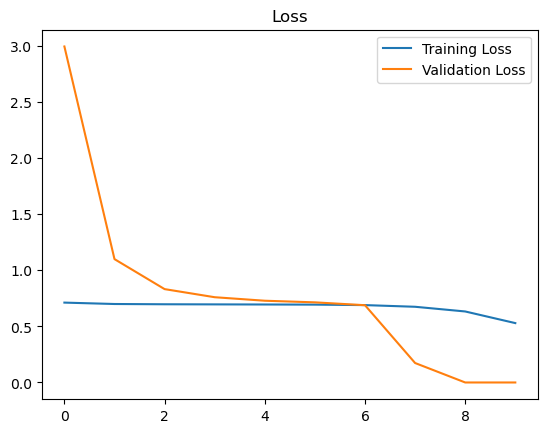

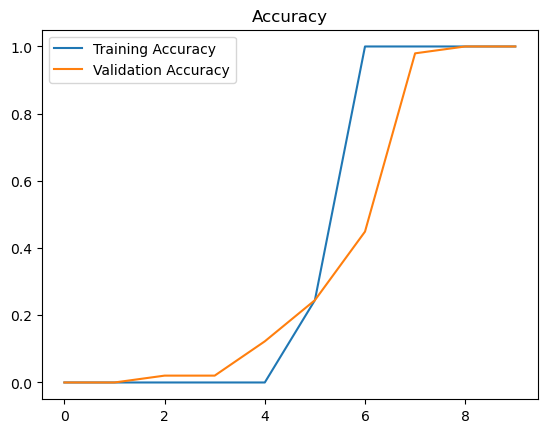

In [35]:
history = model.history.history
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history)

In [44]:
# run model on 50% yes data
model.fit(x=x_yes_50_reconstruction, y=y_yes_50_train, epochs=10, validation_data=(X_yes_50_test, y_yes_50_test))

Epoch 1/10
3/3 [==============================] - 2s 613ms/step - loss: 0.8949 - accuracy: 0.0000e+00 - val_loss: 1.1633 - val_accuracy: 0.1039
Epoch 2/10
3/3 [==============================] - 2s 601ms/step - loss: 0.7602 - accuracy: 0.0000e+00 - val_loss: 0.4209 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - 2s 627ms/step - loss: 0.7167 - accuracy: 0.0000e+00 - val_loss: 0.5046 - val_accuracy: 0.9610
Epoch 4/10
3/3 [==============================] - 2s 565ms/step - loss: 0.6981 - accuracy: 0.1688 - val_loss: 0.5098 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 2s 575ms/step - loss: 0.6820 - accuracy: 1.0000 - val_loss: 0.4745 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 2s 635ms/step - loss: 0.6486 - accuracy: 1.0000 - val_loss: 0.3850 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 2s 575ms/step - loss: 0.5781 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 8/

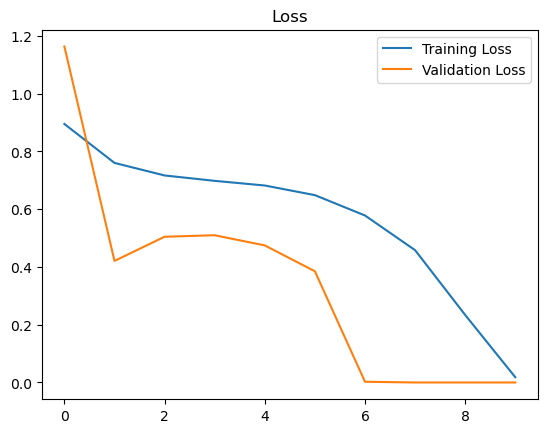

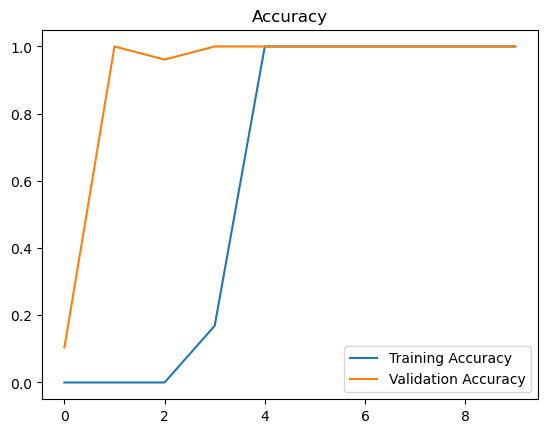

In [45]:
history = model.history.history
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history)

In [53]:
# Train PCA on 75% of dataset
X_no_75_train, X_no_75_test = train_test_split(no_image_pixels_array, test_size = 0.25, random_state = 69)
X_no_75_test = X_no_75_test.reshape(25,128,128)
print(X_no_75_test.shape)
X_no_75_train = X_no_75_train.T
print(X_no_75_train.shape)

X_yes_75_train, X_yes_75_test = train_test_split(yes_image_pixels_array, test_size = 0.25, random_state = 69)
X_yes_75_test = X_yes_75_test.reshape(39,128,128)
print(X_yes_75_test.shape)
X_yes_75_train = X_yes_75_train.T
print(X_yes_75_train.shape)

# y train, binary option tumor or no tumor
y_no_75_train, y_no_75_test = train_test_split(y_no, test_size = 0.25, random_state = 12)
y_yes_75_train, y_yes_75_test = train_test_split(y_yes, test_size = 0.25, random_state = 12)
print(y_no_75_test.shape)
print(y_yes_75_train.shape)

(25, 128, 128)
(16384, 73)
(39, 128, 128)
(16384, 116)
(25,)
(115,)


In [57]:
x_no_75_reconstruction = PCA(X_no_75_train, no_pixel_mu, 5)
x_no_75_reconstruction = x_no_75_reconstruction.T
x_no_75_reconstruction = x_no_75_reconstruction.reshape(73, 128, 128)
print(x_no_75_reconstruction.shape)
x_yes_75_reconstruction = PCA(X_yes_75_train, yes_pixel_mu, 5)
x_yes_75_reconstruction = x_yes_75_reconstruction.T
x_yes_75_reconstruction = x_yes_75_reconstruction.reshape(116,128,128)
x_yes_75_reconstruction = x_yes_75_reconstruction[0:115,:,:]
print(x_yes_75_reconstruction.shape)

(73, 128, 128)
(115, 128, 128)


In [50]:
# Run model on 75% no data
model.fit(x=x_no_75_reconstruction, y=y_no_75_train, epochs=10, validation_data=(X_no_75_test, y_no_75_test))

Epoch 1/10
3/3 [==============================] - 2s 469ms/step - loss: 9.2498 - accuracy: 0.0000e+00 - val_loss: 1221.7720 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 2s 480ms/step - loss: 3.4356 - accuracy: 0.0000e+00 - val_loss: 197.2619 - val_accuracy: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 2s 500ms/step - loss: 1.4768 - accuracy: 0.0000e+00 - val_loss: 8.2262 - val_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 2s 446ms/step - loss: 1.0466 - accuracy: 0.0000e+00 - val_loss: 2.8084 - val_accuracy: 0.0000e+00
Epoch 5/10
3/3 [==============================] - 2s 500ms/step - loss: 0.8206 - accuracy: 0.0000e+00 - val_loss: 0.3073 - val_accuracy: 0.9600
Epoch 6/10
3/3 [==============================] - 2s 455ms/step - loss: 0.6473 - accuracy: 0.6849 - val_loss: 1.6158e-21 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 458ms/step - loss: 0.4014 - accuracy: 1.0000 - val_loss: 0.000

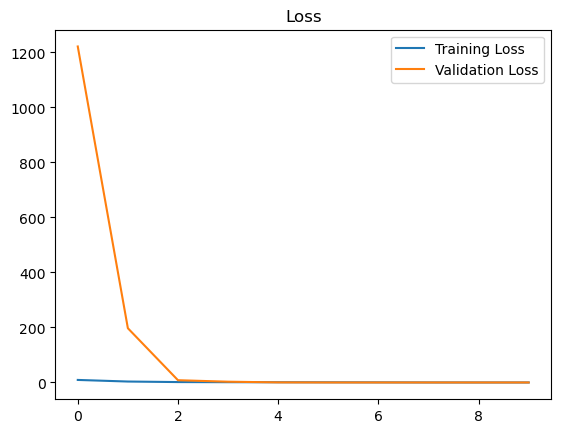

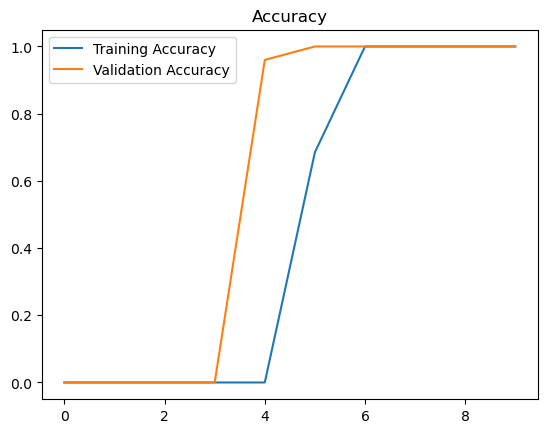

In [51]:
history = model.history.history
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history)

In [58]:
# Run model on 75% yes data
model.fit(x=x_yes_75_reconstruction, y=y_yes_75_train, epochs=10, validation_data=(X_yes_75_test, y_yes_75_test))

Epoch 1/10
4/4 [==============================] - 2s 569ms/step - loss: 16.0544 - accuracy: 0.0000e+00 - val_loss: 2417.9158 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 2s 605ms/step - loss: 4.5862 - accuracy: 0.0000e+00 - val_loss: 413.1958 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 2s 572ms/step - loss: 1.4642 - accuracy: 0.0000e+00 - val_loss: 46.8551 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 2s 536ms/step - loss: 0.8463 - accuracy: 0.0000e+00 - val_loss: 5.9877e-09 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 2s 573ms/step - loss: 0.7294 - accuracy: 0.1217 - val_loss: 4.3244e-12 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 2s 564ms/step - loss: 0.6539 - accuracy: 0.9391 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 2s 584ms/step - loss: 0.4395 - accuracy: 1.0000 - val_loss: 0.0

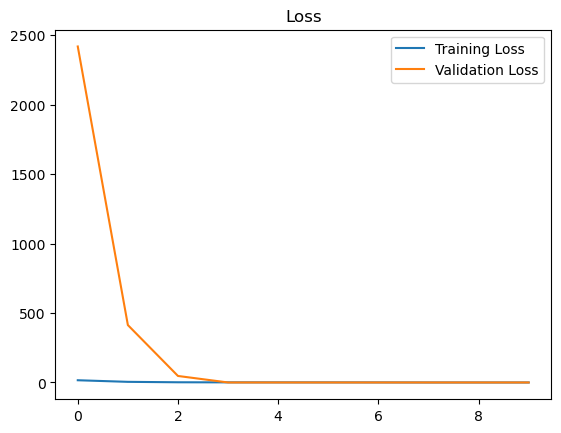

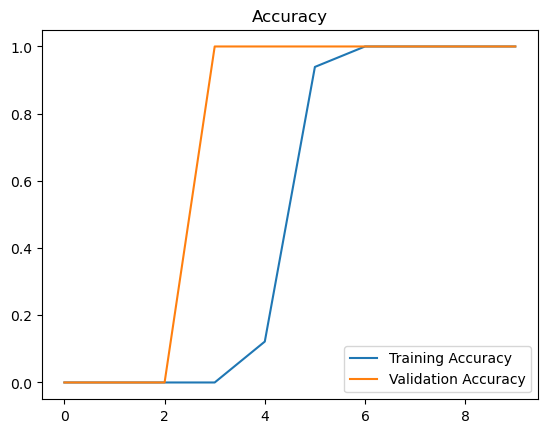

In [59]:
history = model.history.history
model_loss=pd.DataFrame(model.history.history)
plot_metrics(history)